# Iterative Linear Quadratic Regulator

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pydrake.symbolic as sym

## Iterative Linear Quadratic Regulator Derivation

In this exercise we will derive the iterative Linear Quadratic Regulator (iLQR) solving the following optimization problem.

$\begin{aligned} \min_{\mathbf{u}[\cdot]} \quad & \ell_f(\mathbf{x}[N]) + \sum_{n=0}^{N-1} \ell(\mathbf{x}[n],\mathbf{u}[n]) \\ \text{subject to} \quad & \mathbf{x}[n+1] = (\mathbf{x}[n], \mathbf{u}[n]), \quad \forall n\in[0, N-1] \\ & \mathbf{x}[0] = \mathbf{x}_0\end{aligned}$

After completing this exercise you will be able to write your own MPC solver from scratch without any proprietary or third-party software (with the exception of auto-differentiation). You will derive all necessary equations yourself.
While the iLQR algorithm will be capable of solving general model predictive control problems in the form described above, we will apply it to the control of a vehicle. 

### Vehicle Control Problem
Before we start the actual derivation of iLQR we will take a look at the vehicle dynamics and cost functions. The vehicle has the following continuous time dynamics and is controlled by longitudinal acceleration and steering velocity.

In [2]:
n_x = 5
n_u = 2


def car_continuous_dynamics(x, u):
    # x = [x position, y position, heading, speed, steering angle]
    # u = [acceleration, steering velocity]
    m = sym if x.dtype == object else np  # Check type for autodiff
    heading = x[2]
    v = x[3]
    steer = x[4]
    x_d = np.array(
        [v * m.cos(heading), v * m.sin(heading), v * m.tan(steer), u[0], u[1]]
    )
    return x_d

Note that while the vehicle dynamics are in continuous time, our problem formulation is in discrete time. Define the general discrete time dynamics $\bf f$ with a simple [Euler integrator](https://en.wikipedia.org/wiki/Euler_method) in the next cell.

In [3]:
def discrete_dynamics(x, u):
    dt = 0.1
    # TODO: Fill in the Euler integrator below and return the next state

    x_next = x + dt * car_continuous_dynamics(x, u)
    return x_next

Given an initial state $\mathbf{x}_0$ and a guess of a control trajectory $\mathbf{u}[0:N-1]$ we roll out the state trajectory $x[0:N]$ until the time horizon $N$. Please complete the rollout function.

In [4]:
def rollout(x0, u_trj):
    x_trj = np.zeros((u_trj.shape[0] + 1, x0.shape[0]))
    # TODO: Define the rollout here and return the state trajectory x_trj: [N, number of states]
    x_trj[0] = x0
    for i, u in enumerate(u_trj):
        x_trj[i+1] = discrete_dynamics(x_trj[i], u)
    return x_trj


# Debug your implementation with this example code
N = 10
x0 = np.array([1, 0, 0, 1, 0])
u_trj = np.zeros((N - 1, n_u))
x_trj = rollout(x0, u_trj)

We define the stage cost function $\ell$ and final cost function $\ell_f$. The goal of these cost functions is to drive the vehicle along a circle with radius $r$ around the origin with a desired speed.s

$c_{circle} = \sqrt{x_0^2+x_1^2}-r$ penalizes deviation from a circular route

$c_{speed} = (x_3 - v_{target})^2$ penalizes speed differences

$c_{control} = 0.1(u_0^2+u_1^2)$  penalizes too much control up to a scaling factor

In [5]:
r = 2.0
v_target = 2.0
eps = 1e-6  # The derivative of sqrt(x) at x=0 is undefined. Avoid by subtle smoothing


def cost_stage(x, u):
    m = sym if x.dtype == object else np  # Check type for autodiff
    
    c_circle = (m.sqrt(x[0] ** 2 + x[1] ** 2 + eps) - r) ** 2
    c_speed = (x[3] - v_target) ** 2
    c_control = (u[0] ** 2 + u[1] ** 2) * 0.1
    return c_circle + c_speed + c_control


def cost_final(x):
    m = sym if x.dtype == object else np  # Check type for autodiff
    c_circle = (m.sqrt(x[0] ** 2 + x[1] ** 2 + eps) - r) ** 2
    c_speed = (x[3] - v_target) ** 2
    return c_circle + c_speed

Your next task is to write the total cost function of the state and control trajectory. This is simply the sum of all stages over the control horizon and the objective from general problem formulation above.

In [6]:
def cost_trj(x_trj, u_trj):
    total = 0.0
    # TODO: Sum up all costs
    total = (
        cost_final(x_trj[-1])+
        np.sum([cost_stage(x, u) for x, u in zip(x_trj[:-1], u_trj)])
    )

    return total


# Debug your code
cost_trj(x_trj, u_trj)

13.849995624574039

### Bellman Recursion

Now that we are warmed up, let's derive the actual algorithm. We start with the Bellman equation known from lecture defining optimality in a recursively backwards in time.

$$\begin{aligned} V(\mathbf{x}[n]) = & \min_{\mathbf{u}[n]} \quad \ell(\mathbf{x}[n], \mathbf{u}[n])  + V(\mathbf{x}[n+1]) \\ \end{aligned}$$

You may have noticed that we neglected a couple of constraints of the original problem formulation. The fully equivalent formulation is 

$$\begin{aligned} \min_{\mathbf{u}[n]} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]), \quad \forall n\in[0, N-1] \\ \text{subject to} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]) = \ell(\mathbf{x}[n], \mathbf{u}[n])  + V(\mathbf{x}[n+1]) \\ & V(\mathbf{x}[N]) =   \ell_f(\mathbf{x}[N]) \\ & \mathbf{x}[n+1] = {\bf      f}(\mathbf{x}[n], \mathbf{u}[n]), \quad \\ & \mathbf{x}[0] = \mathbf{x}_0 \end{aligned}$$

The definition of a Q-function will become handy during the derivation of the algorithm.

The key idea of iLQR is simple: Approximate the dynamics linearly and the costs quadratically around a nominal trajectory. We will expand all terms of the Q-function accordingly and optimize the resulting quadratic equation for an optimal linear control law in closed form. We will see that by applying the Bellman equation recursively backwards in time, the value function remains a quadratic.
The linear and quadratic approximations are computed around the nominal state $\bf \bar{x} = \bf x - \delta \bf x$ and the nominal control $\bf \bar{u} = \bf u - \delta \bf u$. After applying the Bellman equation backwards in time from time $N$ to $0$ (the backward pass), we will update the nominal controls $\bf \bar{u}$ and states $\bf \bar{x}$ by applying the computed linear feedback law from the backward pass and rolling out the dynamics from the initial state $\bf x_0$ to the final horizon $N$. Iterating between backwards and forwards pass optimizes the control problem.

### Q-function Expansion

Let's start by expanding all terms in the Q-function of the Bellman equation. The quadaratic cost function is

$$\begin{aligned} \ell(\mathbf{x}[n], \mathbf{u}[n]) \approx \ell_n + \begin{bmatrix}\ell_{\mathbf{x},n} \\  \ell_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T \begin{bmatrix}\ell_{\mathbf{xx},n} &  \ell_{\mathbf{ux},n}^T\\ \ell_{\mathbf{ux},n} & \ell_{\mathbf{uu},n}\end{bmatrix} \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix},\end{aligned}$$

and the dynamics function is

$$\begin{aligned} x[n+1]= \mathbf{f}(\mathbf{x}[n], \mathbf{u}[n]) \approx \mathbf{f}_n + \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}. \end{aligned}$$

Here, $\ell = \ell(\bar{\mathbf{x}}, \bar{\mathbf{u}})$ and $\mathbf{f} = \mathbf{f}(\bar{\mathbf{x}}, \bar{\mathbf{u}})$. $\ell_\mathbf{x}, \ell_\mathbf{u}, \mathbf{f}_\mathbf{x}, \mathbf{f}_\mathbf{u}$ are the gradients and Jacobians evaluated at $\bar{\mathbf{x}}$ and $\bar{\mathbf{u}}$. $\ell_\mathbf{xx}, \ell_\mathbf{ux}, \ell_\mathbf{uu}$ are the Hessians at $\bar{\mathbf{x}}$ and $\bar{\mathbf{u}}$. The expansion of the final cost follows analogously.
The code to evaluate all the derivative terms is:

In [7]:
class derivatives:
    def __init__(self, discrete_dynamics, cost_stage, cost_final, n_x, n_u):
        self.x_sym = np.array([sym.Variable("x_{}".format(i)) for i in range(n_x)])
        self.u_sym = np.array([sym.Variable("u_{}".format(i)) for i in range(n_u)])
        x = self.x_sym
        u = self.u_sym

        l = cost_stage(x, u)
        self.l_x = sym.Jacobian([l], x).ravel()
        self.l_u = sym.Jacobian([l], u).ravel()
        self.l_xx = sym.Jacobian(self.l_x, x)
        self.l_ux = sym.Jacobian(self.l_u, x)
        self.l_uu = sym.Jacobian(self.l_u, u)

        l_final = cost_final(x)
        self.l_final_x = sym.Jacobian([l_final], x).ravel()
        self.l_final_xx = sym.Jacobian(self.l_final_x, x)

        f = discrete_dynamics(x, u)
        self.f_x = sym.Jacobian(f, x)
        self.f_u = sym.Jacobian(f, u)

    def stage(self, x, u):
        env = {self.x_sym[i]: x[i] for i in range(x.shape[0])}
        env.update({self.u_sym[i]: u[i] for i in range(u.shape[0])})

        l_x = sym.Evaluate(self.l_x, env).ravel()
        l_u = sym.Evaluate(self.l_u, env).ravel()
        l_xx = sym.Evaluate(self.l_xx, env)
        l_ux = sym.Evaluate(self.l_ux, env)
        l_uu = sym.Evaluate(self.l_uu, env)

        f_x = sym.Evaluate(self.f_x, env)
        f_u = sym.Evaluate(self.f_u, env)

        return l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u

    def final(self, x):
        env = {self.x_sym[i]: x[i] for i in range(x.shape[0])}

        l_final_x = sym.Evaluate(self.l_final_x, env).ravel()
        l_final_xx = sym.Evaluate(self.l_final_xx, env)

        return l_final_x, l_final_xx


derivs = derivatives(discrete_dynamics, cost_stage, cost_final, n_x, n_u)
# Test the output:
x = np.array([0, 0, 0, 0, 0])
u = np.array([0, 0])
# print(derivs.stage(x, u))
# print(derivs.final(x))

Expanding the second term of the Q-function of the Bellman equation, i.e. the value function at the next state $\mathbf{x}[n+1]$, to second order yields 

$$\begin{aligned} V(\mathbf{x}[n+1]) \approx V_{n+1} + V_{\mathbf{x},n+1}^T  \delta \mathbf{x}[n+1] + \frac{1}{2}\delta \mathbf{x}[n+1]^T V_{\mathbf{xx},n+1} \delta \mathbf{x}[n+1],\end{aligned}$$

where $\delta \mathbf{x}[n+1]$ is given by

$$\begin{aligned} \delta \mathbf{x}[n+1] & = \mathbf{x}[n+1] - \bar{\mathbf{x}}[n+1] \\ & = \mathbf{f}_n + \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} &  \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} -  \bar{\mathbf{x}}[n+1] \\ & = \mathbf{f}_n + \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} -  \mathbf{f}(\bar{\mathbf{x}}[n], \bar{\mathbf{u}}[n]) \\ & = \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} &  \mathbf{f}_{\mathbf{u},n} \end{bmatrix}   \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}. \end{aligned}$$

We have now expanded all terms of the Bellman equation and can regroup them in the form of

$$\begin{aligned} Q(\mathbf{x}[n], \mathbf{u}[n]) & \approx \ell_n + \begin{bmatrix}\ell_{\mathbf{x},n} \\  \ell_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T \begin{bmatrix}\ell_{\mathbf{xx},n} &  \ell_{\mathbf{ux},n}^T\\  \ell_{\mathbf{ux},n} & \ell_{\mathbf{uu},n}\end{bmatrix} \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}, \\ & \quad + V_{n+1} + V_{\mathbf{x},n+1}^T  \delta \mathbf{x}[n+1] + \frac{1}{2}\delta \mathbf{x}[n+1]^T V_{\mathbf{xx},n+1} \delta \mathbf{x}[n+1], \\& = Q_n + \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T \begin{bmatrix} Q_{\mathbf{xx},n} & Q_{\mathbf{ux},n}^T\\  Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix} \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}.\end{aligned}$$

Find $Q_{\mathbf{x},n}$, $Q_{\mathbf{u},n}$, $Q_{\mathbf{xx},n}$, $Q_{\mathbf{ux},n}$, $Q_{\mathbf{uu},n}$ in terms of $\ell$ and $\textbf{f}$ and their expansions by collecitng coefficients in $(\cdot)\delta \mathbf{x}[n]$, $(\cdot)\delta \mathbf{u}[n]$, $1/2 \delta \mathbf{x}[n]^T (\cdot) \delta \mathbf{x}[n]$, and similar. Write your results in the corresponding function below.

In [8]:
def Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx):
    # TODO: Define the Q-terms here
    Q_x = l_x + V_x.T @ f_x #np.zeros(l_x.shape)
    Q_u = l_u + V_x.T @ f_u #np.zeros(l_u.shape)
    Q_xx = l_xx + f_x.T @ V_xx @ f_x #np.zeros(l_xx.shape)
    Q_ux = l_ux + f_u.T @ V_xx @ f_x #np.zeros(l_ux.shape)
    Q_uu = l_uu + f_u.T @ V_xx @ f_u #np.zeros(l_uu.shape)
    return Q_x, Q_u, Q_xx, Q_ux, Q_uu

### Q-function Optimization and Optimal Linear Control Law
Amazing! Now that we have the Q-function in quadratic form, we can optimize for the optimal control gains in closed form.
The original formulation, i.e. optimizing over $\mathbf{u}[n]$, $$\begin{aligned} \min_{\mathbf{u}[n]} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]),\end{aligned}$$ is equivalent to optimzing over $\delta \mathbf{u}[n]$.

$$\begin{aligned} \delta \mathbf{u}[n]^* = {\arg\!\min}_{\delta \mathbf{u}[n]} \quad Q_n  + \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix} ^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} ^T \begin{bmatrix} Q_{\mathbf{xx},n} &  Q_{\mathbf{ux},n}^T\\  Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} = k + K \delta \mathbf{x}[n]\end{aligned}$$

It turns out that the optimal control is linear in $\delta \mathbf{x}[n]$.
Solve the quadratic optimization analytically and derive equations for the feedforward gains $k$ and feedback gains $K$. Implement the function below. Hint: You do not need to compute $Q_\mathbf{uu}^{-1}$ by hand.

In [9]:
def gains(Q_uu, Q_u, Q_ux):
    Q_uu_inv = np.linalg.inv(Q_uu)
    # TODO: Implement the feedforward gain k and feedback gain K.
    k = - Q_uu_inv @ Q_u.T  #np.zeros(Q_u.shape)
    K = - Q_uu_inv @ Q_ux #np.zeros(Q_ux.shape)
    return k, K

### Value Function Backward Update
We are almost done! We need to derive the backwards update equation for the value function. We simply plugin the optimal control $\delta \mathbf{u}[n]^* = k + K \delta \mathbf{x}[n]$ back into the Q-function which yields the value function

$$\begin{aligned} V(\mathbf{x}[n]) \approx V_{n} + V_{\mathbf{x},n}^T  \delta \mathbf{x}[n] + \frac{1}{2}\delta \mathbf{x}[n]^T V_{\mathbf{xx},n} \delta \mathbf{x}[n] = Q_n + \begin{bmatrix} Q_{\mathbf{x},n} \\  Q_{\mathbf{u},n} \end{bmatrix}^T  \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix} + \frac{1}{2}\begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix}^T \begin{bmatrix} Q_{\mathbf{xx},n} &  Q_{\mathbf{ux},n}^T\\  Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n}\end{bmatrix} \begin{bmatrix} \delta \mathbf{x}[n] \\ \delta \mathbf{u}[n]^* \end{bmatrix}. \end{aligned}$$

Compare terms in $(\cdot) \delta \mathbf{x}[n]$ and $ 1/2 \delta \mathbf{x}[n]^T (\cdot)  \delta \mathbf{x}[n]$, find $V_{\mathbf{x},n}$, and $V_{\mathbf{xx},n}$ and implement the corresponding function below.

IMPORTANT: Do not simplify the expression you obtain for $V_{x}$ and $V_{xx}$ by assuming that $k$ and $K$ have the form computed by the function `gains`.

In [10]:
def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    # TODO: Implement V_x and V_xx, hint: use the A.dot(B) function for matrix multiplcation.
    V_x = Q_x + K.T @ Q_u + k.T @ Q_ux + K.T @ Q_uu @ k #np.zeros(Q_x.shape)
    # print(Q_xx.shape, Q_ux.T.shape, K.shape, K.T.shape, Q_ux.shape, K.shape)  #np.zeros(Q_xx.shape)
    V_xx = Q_xx + 2 * Q_ux.T @ K + K.T @ Q_uu @ K  #np.zeros(Q_xx.shape) 
    
    return V_x, V_xx

### Expected Cost Reduction
We can also estimate by how much we expect to reduce the cost by applying the optimal controls. Simply subtract the previous nominal Q-value ($\delta \mathbf{x}[n] = 0$ and $\delta \mathbf{u}[n]=0$) from the value function.  The result is implemented below and is a useful aid in checking how accurate the quadratic approximation is during convergence of iLQR and adapting stepsize and regularization.

In [11]:
def expected_cost_reduction(Q_u, Q_uu, k):
    return -Q_u.T.dot(k) - 0.5 * k.T.dot(Q_uu.dot(k))

### Forward Pass
We have now have all the ingredients to implement the forward pass and the backward pass of iLQR. In the forward pass, at each timestep the new updated control $\mathbf{u}' =  \bar{\mathbf{u}} + k + K (x' - \bar{\mathbf{x}})$ is applied and the dynamis propagated based on the updated control. The nominal control and state trajectory $\bar{\mathbf{u}}, \bar{\mathbf{x}}$ with which we computed $k$ and $K$ are then updated and we receive a new set of state and control trajectories.

In [12]:
def forward_pass(x_trj, u_trj, k_trj, K_trj):
    x_trj_new = np.zeros(x_trj.shape)
    x_trj_new[0, :] = x_trj[0, :]
    u_trj_new = np.zeros(u_trj.shape)
    # TODO: Implement the forward pass here
    for n in range(u_trj.shape[0]):
        # Note, converting from deviation variable to actual value variable
        u_trj_new[n,:] = u_trj[n,:] + k_trj[n,:] + K_trj[n,:] @ (x_trj_new[n,:]-x_trj[n,:])# Apply feedback law
        x_trj_new[n+1,:] = discrete_dynamics(x_trj_new[n,:], u_trj_new[n,:]) # Apply dynamics
    return x_trj_new, u_trj_new

### Backward Pass
The backward pass starts from the terminal boundary condition $V(\mathbf{x}[N]) =   \ell_f(\mathbf{x}[N])$, such that $V_{\mathbf{x},N} = \ell_{\mathbf{x},f}$ and $V_{\mathbf{xx},N} = \ell_{\mathbf{xx},f}$. In the backwards loop terms for the Q-function at $n$ are computed based on the quadratic value function approximation at $n+1$ and the derivatives and hessians of dynamics and cost functions at $n$. To solve for the gains $k$ and $K$ an inversion of the matrix $Q_\mathbf{uu}$ is necessary. To ensure invertability and to improve conditioning we add a diagonal matrix to $Q_\mathbf{uu}$. This is equivalent to adding a quadratic penalty on the distance of the new control trajectory from the control trajectory of the previous iteration. The result is a smaller stepsize and more conservative convergence properties.

In [13]:
def backward_pass(x_trj, u_trj, regu):
    k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
    K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
    expected_cost_redu = 0
    # TODO: Set terminal boundary condition here (V_x, V_xx)
    V_x, V_xx = derivs.final(x_trj[-1])
    # print(x_trj.shape[1], u_trj.shape[1])
    # print(V_x.shape)
    # print(V_xx.shape)
    # V_x = np.zeros((x_trj.shape[1],))
    # V_xx = np.zeros((x_trj.shape[1], x_trj.shape[1]))
    for n in range(u_trj.shape[0] - 1, -1, -1):
        # TODO: First compute derivatives, then the Q-terms
        l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u = derivs.stage(x_trj[n], u_trj[n])
        # print(l_ux.shape, f_u.shape, V_xx.shape, f_x.T.shape )
        Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)
        # Q_x = np.zeros((x_trj.shape[1],))
        # Q_u = np.zeros((u_trj.shape[1],))
        # Q_xx = np.zeros((x_trj.shape[1], x_trj.shape[1]))
        # Q_ux = np.zeros((u_trj.shape[1], x_trj.shape[1]))
        # Q_uu = np.zeros((u_trj.shape[1], u_trj.shape[1]))
        # We add regularization to ensure that Q_uu is invertible and nicely conditioned
        Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0]) * regu
        k, K = gains(Q_uu_regu, Q_u, Q_ux)
        k_trj[n, :] = k
        K_trj[n, :, :] = K
        V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
        expected_cost_redu += expected_cost_reduction(Q_u, Q_uu, k)
    return k_trj, K_trj, expected_cost_redu

### Main Loop

The main iLQR loop consists of iteratively applying the forward and backward pass. The regularization is adapted based on whether the new control and state trajectories improved the cost. We lower the regularization if the total cost was reduced and accept the new trajectory pair. If the total cost did not decrease, the trajectory pair is rejected and the regularization is increased. You may want to test the algorithm with deactivated regularization and observe the changed behavior.
The main loop stops if the maximum number of iterations is reached or the expected reduction is below a certain threshold.

If you have correctly implemented all subparts of the iLQR you should see that the car plans to drive around the circle.

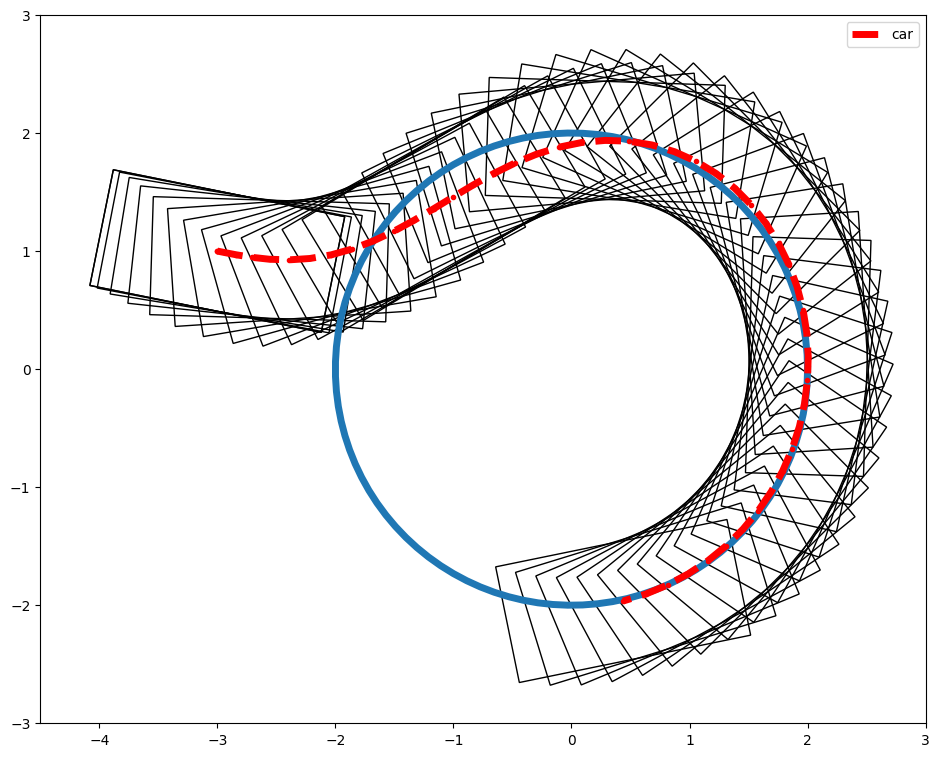

In [14]:
def run_ilqr(x0, N, max_iter=50, regu_init=100):
    # First forward rollout
    u_trj = np.random.randn(N - 1, n_u) * 0.0001
    x_trj = rollout(x0, u_trj)
    total_cost = cost_trj(x_trj, u_trj)
    regu = regu_init
    max_regu = 10000
    min_regu = 0.01

    # Setup traces
    cost_trace = [total_cost]
    expected_cost_redu_trace = []
    redu_ratio_trace = [1]
    redu_trace = []
    regu_trace = [regu]

    # Run main loop
    for it in range(max_iter):
        # Backward and forward pass
        k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj, regu)
        x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj)
        # Evaluate new trajectory
        total_cost = cost_trj(x_trj_new, u_trj_new)
        cost_redu = cost_trace[-1] - total_cost
        redu_ratio = cost_redu / abs(expected_cost_redu)
        # Accept or reject iteration
        if cost_redu > 0:
            # Improvement! Accept new trajectories and lower regularization
            redu_ratio_trace.append(redu_ratio)
            cost_trace.append(total_cost)
            x_trj = x_trj_new
            u_trj = u_trj_new
            regu *= 0.7
        else:
            # Reject new trajectories and increase regularization
            regu *= 2.0
            cost_trace.append(cost_trace[-1])
            redu_ratio_trace.append(0)
        regu = min(max(regu, min_regu), max_regu)
        regu_trace.append(regu)
        redu_trace.append(cost_redu)

        # Early termination if expected improvement is small
        if expected_cost_redu <= 1e-6:
            break

    return x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace


# Setup problem and call iLQR
x0 = np.array([-3.0, 1.0, -0.2, 0.0, 0.0])
N = 50
max_iter = 50
regu_init = 100
x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace = run_ilqr(
    x0, N, max_iter, regu_init
)


plt.figure(figsize=(9.5, 8))
# Plot circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(r * np.cos(theta), r * np.sin(theta), linewidth=5)
ax = plt.gca()

# Plot resulting trajecotry of car
plt.plot(x_trj[:, 0], x_trj[:, 1], 'r.--',linewidth=5, label='car')
w = 2.0
h = 1.0

# Plot rectangles
for n in range(x_trj.shape[0]):
    rect = mpl.patches.Rectangle((-w / 2, -h / 2), w, h, fill=False)
    t = (
        mpl.transforms.Affine2D()
        .rotate_deg_around(0, 0, np.rad2deg(x_trj[n, 2]))
        .translate(x_trj[n, 0], x_trj[n, 1])
        + ax.transData
    )
    rect.set_transform(t)
    ax.add_patch(rect)
ax.set_aspect(1)
plt.ylim((-3, 3))
plt.xlim((-4.5, 3))
plt.tight_layout()
plt.legend()

In [15]:
x_trj[:, 0], x_trj[:, 1]

(array([-3.        , -3.        , -2.94083136, -2.83993574, -2.70940129,
        -2.5577048 , -2.39134197, -2.21590567, -2.0363648 , -1.85672521,
        -1.67959467, -1.50605512, -1.33587039, -1.16785456, -1.00025397,
        -0.83108744, -0.65844611, -0.48076947, -0.29710275, -0.10731818,
         0.08774262,  0.28625751,  0.48557553,  0.68251165,  0.87371035,
         1.05598263,  1.22654544,  1.38313959,  1.52404313,  1.64801567,
         1.7542098 ,  1.84207659,  1.91128163,  1.96163966,  1.99307012,
         2.00557241,  1.99921787,  1.97415494,  1.93062306,  1.86897153,
         1.78967931,  1.69337254,  1.58083721,  1.45302509,  1.31105233,
         1.15619112,  0.98985532,  0.81358219,  0.62901198,  0.43786748]),
 array([ 1.        ,  1.        ,  0.98800592,  0.96847036,  0.94711802,
         0.93064931,  0.92558794,  0.93702884,  0.96770651,  1.01776235,
         1.08524787,  1.16696187,  1.25917205,  1.35803588,  1.459759  ,
         1.56059935,  1.65681185,  1.74460263,  1

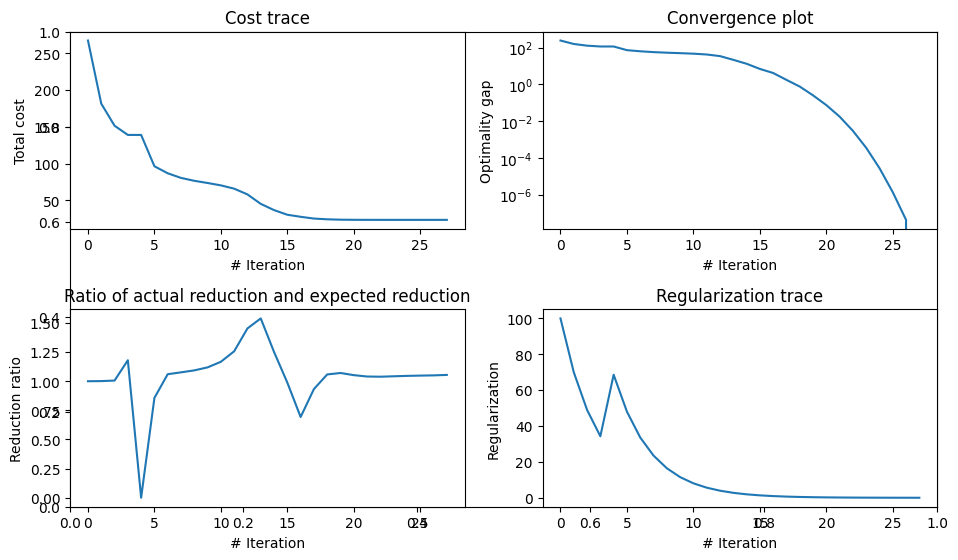

In [16]:
plt.subplots(figsize=(10, 6))
# Plot results
plt.subplot(2, 2, 1)
plt.plot(cost_trace)
plt.xlabel("# Iteration")
plt.ylabel("Total cost")
plt.title("Cost trace")

plt.subplot(2, 2, 2)
delta_opt = np.array(cost_trace) - cost_trace[-1]
plt.plot(delta_opt)
plt.yscale("log")
plt.xlabel("# Iteration")
plt.ylabel("Optimality gap")
plt.title("Convergence plot")

plt.subplot(2, 2, 3)
plt.plot(redu_ratio_trace)
plt.title("Ratio of actual reduction and expected reduction")
plt.ylabel("Reduction ratio")
plt.xlabel("# Iteration")

plt.subplot(2, 2, 4)
plt.plot(regu_trace)
plt.title("Regularization trace")
plt.ylabel("Regularization")
plt.xlabel("# Iteration")
plt.tight_layout()

### Convergence Analysis
You can find some plots of the convergence traces captured throughout the iLQR solve process above. The convergence plot indicates that we have achieved superlinear convergence. In fact, iLQR achieves nearly second order convergence. In the case of linear convergence (e.g. gradient descent), the [graph would show a line](https://en.wikipedia.org/wiki/Rate_of_convergence). While the integrated regularization improves robustness it damps convergence in the early iteration steps. 

In the ideal case, the expected reduction and the actual reduction should be the same, i.e. the reduction ratio remains around 1. If that is the case, the quadratic approximation of costs and linear approximation of the dynamics are very accurate. If the ratio becomes significantly lower than 1, the regularization needs to be increased and thus the stepsize reduced.

## Autograding
You can check your work by running the following cell.

In [17]:
from underactuated.exercises.grader import Grader
from underactuated.exercises.trajopt.test_ilqr_driving import TestIlqrDriving

Grader.grade_output([TestIlqrDriving], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 18/18.

Score for Test discrete_dynamics is 1/1.

Score for Test rollout is 1/1.

Score for Test cost_trj is 1/1.

Score for Test Q_terms is 5/5.

Score for Test gains is 3/3.

Score for Test V_terms is 3/3.

Score for Test forward_pass is 2/2.

Score for Test backward_pass is 2/2.


In [18]:
# locals()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=05031f8c-3586-4b47-be79-7f4893cf2f9d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>